<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting in TensorFlow 

 
* Get time series data (the historical price of Bitcoin)
  * Load in time series data using pandas/Python's CSV module
* Format data for a time series problem
  * Creating training and test sets (the wrong way)
  * Creating training and test sets (the right way)
  * Visualizing time series data
  * Turning time series data into a supervised learning problem (windowing)
  * Preparing univariate and multivariate (more than one variable) data
* Evaluating a time series forecasting model
* Setting up a series of deep learning modelling experiments
  * Dense (fully-connected) networks
  * Sequence models (LSTM and 1D CNN)
  * Ensembling (combining multiple models together)
  * Multivariate models
  * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
* Creating a modelling checkpoint to save the best performing model during training
* Making predictions (forecasts) with a time series model
* Creating prediction intervals for time series model forecasts
* Discussing two different types of uncertainty in machine learning (data uncertainty and model uncertainty)
* Demonstrating why forecasting in an open system is BS (the turkey problem) 

 

## Check for GPU
 


In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1050 Ti (UUID: GPU-d41e41d3-8353-b965-cc26-d6865e745952)


## Get data



In [2]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

'wget' is not recognized as an internal or external command,
operable program or batch file.


### Importing time series data with pandas


In [4]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


Looking good! Let's get some more info.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


Because we told pandas to parse the date column and set it as the index, its not in the list of columns.

You can also see there isn't many samples.

In [6]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's only 2787 total samples.

 

| 1 sample per timeframe | Number of samples per year |
| ----- | ----- |
| Second | 31,536,000 |
| Hour | 8,760 |
| Day | 365 |
| Week | 52 |
| Month | 12 |

> 🔑 

In [7]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


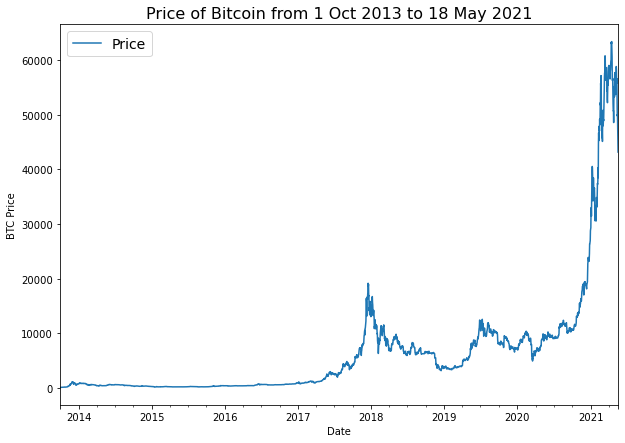

In [8]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

Woah, looks like it would've been a good idea to buy Bitcoin back in 2014.

### Importing time series data with Python's CSV module



In [10]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

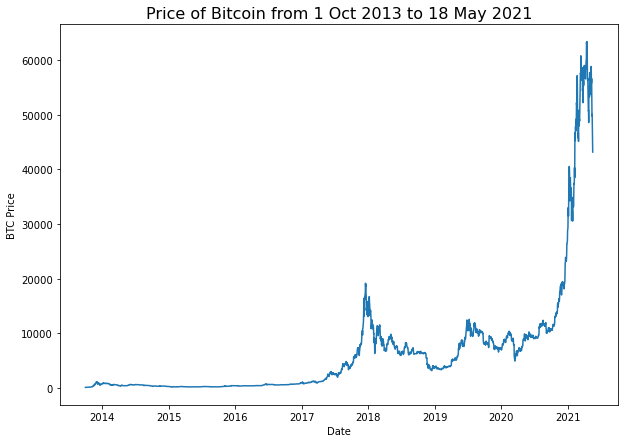

In [11]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

## Format Data Part 1: Creatining train and test sets for time series data

 

### Create train & test sets for time series (the wrong way)



In [12]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

And now we'll use the ever faithful `train_test_split` from Scikit-Learn to create our train and test sets.

In [13]:
# Wrong way to make train/test sets for time series
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((2229,), (558,), (2229,), (558,))

Looks like the splits worked well, but let's not trust numbers on a page, let's visualize, visualize, visualize!

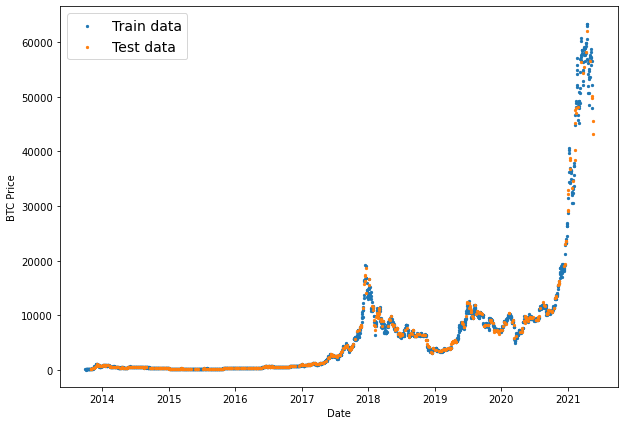

In [14]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train & test sets for time series (the right way)

 

In [15]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

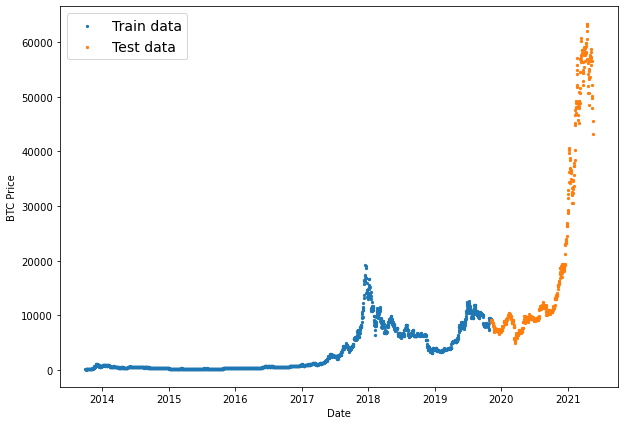

In [16]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create a plotting function

Rather than retyping `matplotlib` commands to continuously plot data, let's make a plotting function we can reuse later.

In [17]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

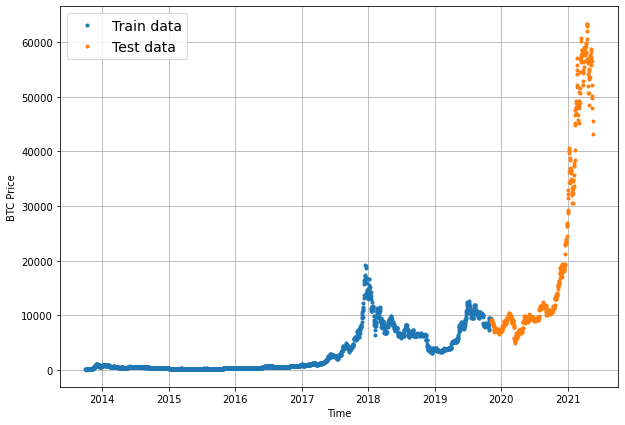

In [18]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

Looking good!

Time for some modelling experiments.

In [21]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10 

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

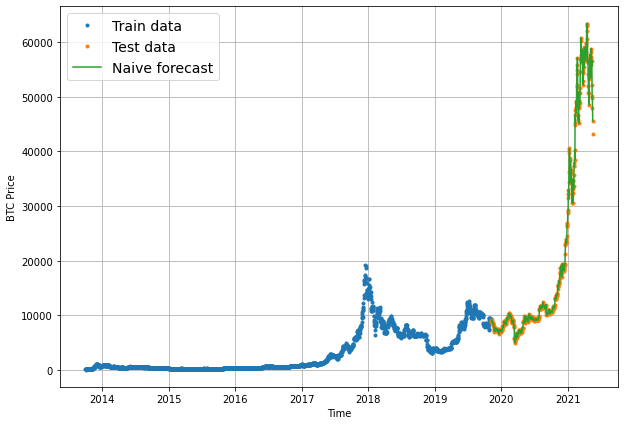

In [23]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

The naive forecast looks like it's following the data well. 

Let's zoom in to take a better look.

We can do so by creating an offset value and passing it to the `start` parameter of our `plot_time_series()` function.

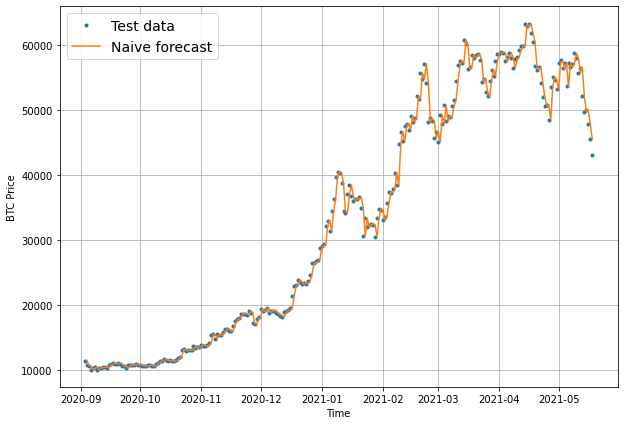

In [107]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

In [24]:
# Let's get TensorFlow! 
import tensorflow as tf

In [25]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [26]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Looking good! How about we test our function on the naive forecast?

In [27]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [28]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737226

In [29]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

Now we'll write a function to take in an array and turn it into a window and horizon.

In [30]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [31]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [32]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

Phew! A few steps there... let's see how it goes.

In [33]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

Of course we have to visualize, visualize, visualize!

In [34]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [35]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


In [36]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

Look at that amazing function, lets test it.

In [37]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

Notice the default split of 80% training data and 20% testing data (this split can be adjusted if needed).

How do the first 5 samples of the training windows and labels looks?

In [38]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [39]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

In [40]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

In [41]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=50,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/50
18/18 [==============================] - 1s 55ms/step - loss: 972.5546 - mae: 972.5546 - val_loss: 2782.5291 - val_mae: 2782.5291
Epoch 2/50
18/18 [==============================] - 1s 36ms/step - loss: 272.7716 - mae: 272.7716 - val_loss: 1136.9102 - val_mae: 1136.9102
Epoch 3/50
18/18 [==============================] - 0s 29ms/step - loss: 189.5964 - mae: 189.5964 - val_loss: 979.2823 - val_mae: 979.2823
Epoch 4/50
18/18 [==============================] - 0s 28ms/step - loss: 177.1296 - mae: 177.1296 - val_loss: 971.1274 - val_mae: 971.1274
Epoch 5/50
18/18 [==============================] - 1s 30ms/step - loss: 172.5925 - mae: 172.5925 - val_loss: 936.4932 - val_mae: 936.4932
Epoch 6/50
18/18 [==============================] - 0s 28ms/step - loss: 170.3895 - mae: 170.3895 - val_loss: 917.9744 - val_mae: 917.9744
Epoch 7/50
18/18 [==============================] - 0s 27ms/step - loss: 162.0635 - mae: 162.0635 - val_loss: 902.3209 - val_mae: 902.3209
Epoch 8/50
18/18 [=====

In [42]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


Because of the small size of our data (less than 3000 total samples), the model trains very fast.

Let's evaluate it.

In [43]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 612.6789 - mae: 612.6789


[612.6788940429688, 612.6788940429688]

You'll notice the model achieves the same `val_loss` (in this case, this is MAE) as the last epoch.

But if we load in the version of `model_1` which was saved to file using the `ModelCheckpoint` callback, we should see an improvement in results.

In [44]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 599.2580 - mae: 599.2580


[599.2579956054688, 599.2579956054688]

Much better! Due to the fluctuating performance of the model during training, loading back in the best performing model see's a sizeable improvement in MAE.

In [45]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

Nice! 

Now let's use our `make_preds()` and see how it goes.



In [46]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8959.415, 8824.7  , 8966.85 , 8886.551, 8781.875, 8659.543,
        8765.922, 8592.071, 8451.733, 8537.931], dtype=float32)>)

In [47]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 599.258,
 'mse': 1256225.6,
 'rmse': 1120.8147,
 'mape': 2.7131338,
 'mase': 1.0527303}

How did our model go? Did it beat the naïve forecast?

In [48]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

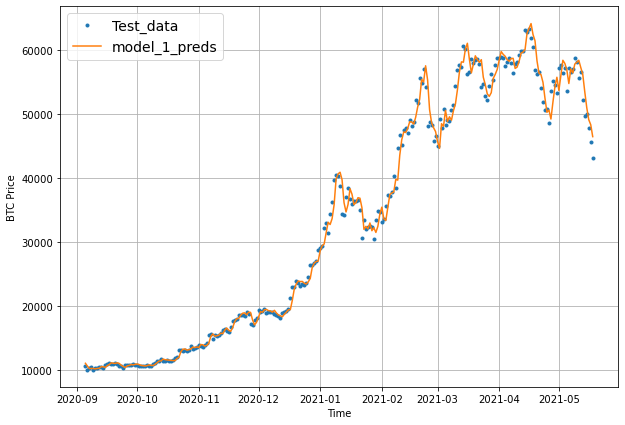

In [49]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

What's wrong with these predictions?

As mentioned before, they're on the test dataset. So they're not actual forecasts.

With our current model setup, how do you think we'd make forecasts for the future?

Have a think about it for now, we'll cover this later on.

In [50]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [51]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [52]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

Data prepared!

Now let's construct `model_2`, a model with the same architecture as `model_1` as well as the same training routine.

In [53]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=50,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: mod

Once again, training goes nice and fast.

Let's evaluate our model's performance.

In [54]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 796.6062


796.606201171875

Hmmm... is that the best it did?

How about we try loading in the best performing `model_2` which was saved to file thanks to our `ModelCheckpoint` callback.

In [55]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 645.5732


645.5731811523438

In [56]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [57]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 645.57336,
 'mse': 1394154.0,
 'rmse': 1180.743,
 'mape': 3.0117738,
 'mase': 1.1284686}

It looks like `model_2` performs worse than the naïve model as well as `model_1`!

Does this mean a smaller window size is better? (I'll leave this as a challenge you can experiment with)

How do the predictions look?

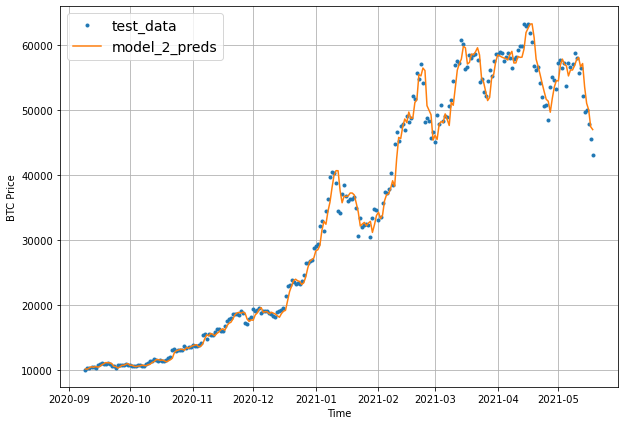

In [58]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds") 

In [59]:
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               3968      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


## Model 3: Dense (window = 30, horizon = 7)

Let's try and predict 7 days ahead given the previous 30 days.

First, we'll update the `HORIZON` and `WINDOW_SIZE` variables and create windowed data.


In [60]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

And we'll split the full dataset windows into training and test sets.

In [61]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

Now let's build, compile, fit and evaluate a model.

In [62]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=50,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: mod

In [63]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1285.2476


1285.24755859375

To compare apples to apples (best performing model to best performing model), we've got to load in the best version of `model_3`. 

In [64]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1285.2476


1285.24755859375

In this case, the error will be higher because we're predicting 7 steps at a time. 

This makes sense though because the further you try and predict, the larger your error will be (think of trying to predict the weather 7 days in advance).

Let's make predictions with our model using the `make_preds()` function and evaluate them using the `evaluate_preds()` function.

In [65]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9514.146, 9262.387, 9572.427, 9321.   , 9225.87 , 9591.224,
        9444.175],
       [9095.346, 8965.848, 9234.075, 9143.85 , 8730.712, 9354.711,
        8961.033],
       [8892.419, 8898.687, 9116.271, 8901.661, 8716.676, 8998.25 ,
        8853.021],
       [9156.825, 9043.012, 9139.709, 8906.559, 8804.826, 9005.126,
        8995.25 ],
       [9089.448, 8834.902, 8825.912, 8901.913, 8798.955, 9003.318,
        8902.523]], dtype=float32)>

In [66]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 625.5319  ,  356.43988 ,  260.64453 ,  380.73492 ,  353.79117 ,
         406.4935  ,  483.0057  ,  555.4356  ,  642.8706  ,  661.9746  ,
         737.224   ,  706.47235 ,  934.6503  ,  894.7084  ,  544.4414  ,
         354.774   ,  283.2022  ,  262.08463 ,  281.2188  ,  291.75125 ,
         162.56717 ,  158.00453 ,  213.28426 ,  256.71136 ,  219.90535 ,
         200.0053  ,  166.07088 ,  106.976845,  200.49477 ,  212.89217 ,
         322.0286  ,  426.25467 ,  365.86105 ,  364.8044  ,  290.6888  ,
         291.63162 ,  325.4949  ,  277.0472  ,  187.271   ,  239.07024 ,
         394.6932  ,  100.01137 ,  118.93478 ,  109.27135 ,  106.00035 ,
          92.191124,   78.78132 ,  180.21924 ,  162.47112 ,  108.91302 ,
         143.59236 ,  186.655   ,  146.42278 ,  229.33168 ,  298.80573 ,
         383.50406 ,  472.38895 ,  537.5581  ,  572.797   ,  593.7589  ,
         423.9603  ,  312.56326 ,  364.29688 ,  434.4128  ,  483.01166 ,
         508.00278 ,  489.3123  ,  478.48856

In [67]:
model_3.summary()

Model: "model_3_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               3968      
                                                                 
 dense_5 (Dense)             (None, 7)                 903       
                                                                 
Total params: 4,871
Trainable params: 4,871
Non-trainable params: 0
_________________________________________________________________


## Make our evaluation function work for larger horizons



In [68]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Now we've updated `evaluate_preds()` to work with multiple shapes, how does it look?

In [69]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1285.2476,
 'mse': 5613983.5,
 'rmse': 1477.187,
 'mape': 5.7566066,
 'mase': 2.2870257}

Time to visualize.

If our prediction evaluation metrics were mutli-dimensional, how do you think the predictions will look like if we plot them?

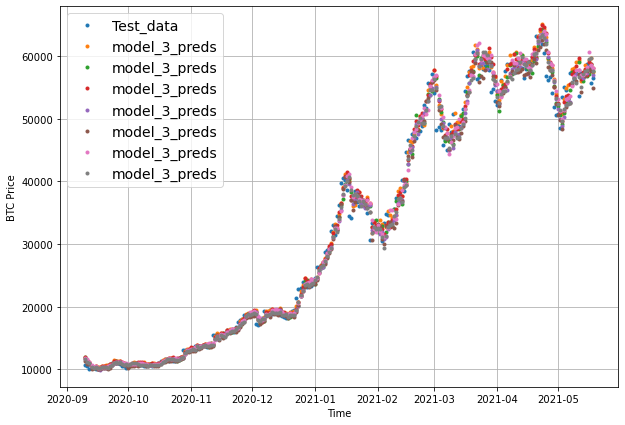

In [70]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

When we try to plot our multi-horizon predicts, we get a funky looking plot.

Again, we can fix this by aggregating our model's predictions.

> 🔑 **Note:** Aggregating the predictions (e.g. reducing a 7-day horizon to one value such as the mean) loses information from the original prediction. As in, the model predictions were trained to be made for 7-days but by reducing them to one, we gain the ability to plot them visually but we lose the extra information contained across multiple days.

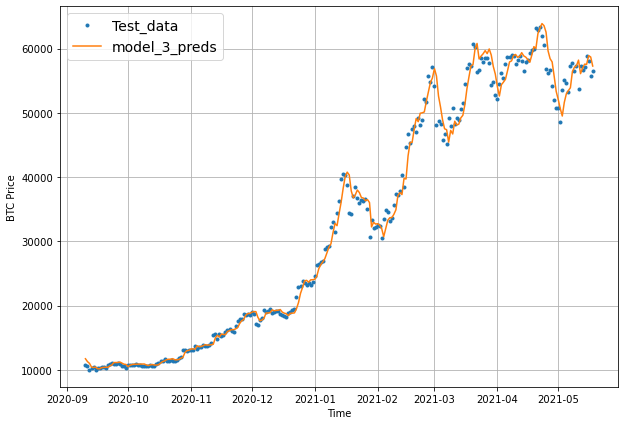

In [71]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

## Which of our models is performing best so far?

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naïve model to see which model is performing the best so far.

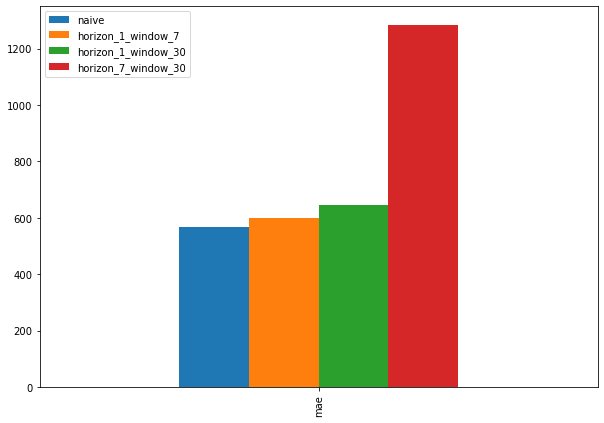

In [72]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

Woah, our naïve model is performing best (it's very hard to beat a naïve model in open systems) but the dense model with a horizon of 1 and a window size of 7 looks to be performing cloest.

Because of this, let's use `HORIZON=1` and `WINDOW_SIZE=7` for our next series of modelling experiments (in other words, we'll use the previous week of Bitcoin prices to try and predict the next day).

> 🔑 **Note:** You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of **autocorrelation** in the data. If a time series has **autocorrelation** it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is, a naïve model will often get fairly good results.

> 📖 **Resource:** For more on how autocorrelation influences a model's predictions, see the article [*How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls*](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424) by Vegard Flovik

In [73]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [74]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [75]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [77]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [78]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


Looking good!

Now we've got a Lambda layer, let's build, compile, fit and evaluate a Conv1D model on our data.

> 🔑 **Note:** If you run the model below without the Lambda layer, you'll get an input shape error (one of the most common errors when building neural networks).

In [79]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=80,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


What does the Lambda layer look like in a summary?

In [80]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


The Lambda layer appears the same as any other regular layer. 

Time to evaluate the Conv1D model.

In [81]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 573.7255


573.7255249023438

In [82]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8909.864, 8796.134, 8992.685, 8786.074, 8752.468, 8751.412,
       8682.784, 8537.95 , 8475.386, 8516.62 ], dtype=float32)>

In [83]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 573.7255,
 'mse': 1193796.9,
 'rmse': 1092.6101,
 'mape': 2.5681117,
 'mase': 1.0078769}

## Model 5: RNN (LSTM)

 

In [89]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_5.fit(train_windows,
            train_labels,
            epochs=120,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets


In [90]:
model_5.summary()

Model: "model_5_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_3 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               69632     
                                                                 
 dense_9 (Dense)             (None, 32)                4128      
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 74,849
Trainable params: 74,849
Non-trai

In [91]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.0328


568.0328369140625

Now we've got the best performing LSTM model loaded in, let's make predictions with it and evaluate them.

In [92]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8874.656, 8783.858, 9001.114, 8777.031, 8735.805, 8733.79 ,
       8669.377, 8528.447, 8455.852, 8511.442], dtype=float32)>

In [93]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 568.0328,
 'mse': 1170161.9,
 'rmse': 1081.7402,
 'mape': 2.5410707,
 'mase': 0.9978762}

## Make a multivariate time series 

 

In [111]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [112]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [113]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

Now we can add another feature to our dataset `block_reward` (this gets lower over time so it may lead to increasing prices of Bitcoin).

In [114]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


Woohoo! We've officially added another variable to our time series data.

Let's see what it looks like.

Text(0.5, 1.0, 'multivariate model coupling block reward knoweldge')

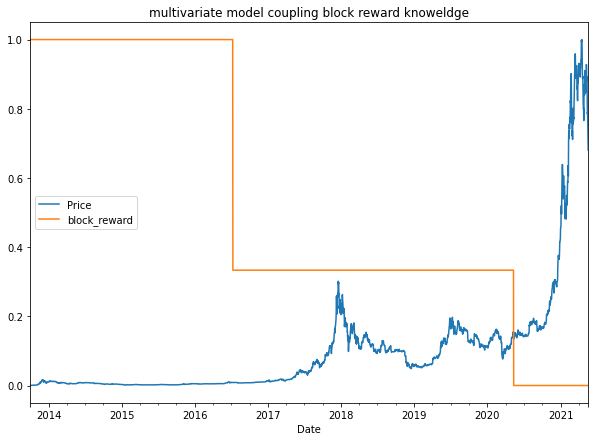

In [169]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));
plt.title('multivariate model coupling block reward knoweldge')

## Making a windowed dataset with pandas

 

In [116]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [117]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [118]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [119]:
# View labels
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

What a good looking dataset, let's split it into train and test sets using an 80/20 split just as we've done before.

In [120]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

Training and test multivariate time series datasets made! Time to build a model.

## Model 6: Dense (multivariate time series)

 

In [121]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=120,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


In [122]:
model_6.summary()

Model: "model_6_dense_multivariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               1152      
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [123]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 568.1834


568.1834106445312

In [124]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8845.445, 8772.664, 9060.355, 8765.934, 8731.343, 8771.575,
       8679.82 , 8496.494, 8480.422, 8531.794], dtype=float32)>

In [125]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 568.1832,
 'mse': 1159775.8,
 'rmse': 1076.9288,
 'mape': 2.529535,
 'mase': 0.9981406}

Hmmm... how do these results compare to `model_1` (same window size and horizon but without the block reward feature)?

In [126]:
model_1_results

{'mae': 599.258,
 'mse': 1256225.6,
 'rmse': 1120.8147,
 'mape': 2.7131338,
 'mase': 1.0527303}

## Model 7: N-BEATS algorithm

 

### Building and testing an N-BEATS block layer

Let's start by building an N-BEATS block layer, we'll write the code first and then discuss what's going on.

In [127]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [128]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [129]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>

In [130]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.16897504  0.84619     1.4174215  -0.83255535  0.5823934  -0.15420172
  0.47122666]
Forecast: -0.564083993434906


In [131]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [132]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [133]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [134]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [135]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

Data prepared! Notice the input shape for the features `(None, 7)`, the `None` leaves space for the batch size where as the `7` represents the `WINDOW_SIZE`.

Time to get create the N-BEATS architecture. 

In [136]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [137]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [138]:
 %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 220: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 320: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: total: 1h 28min 15s
Wall time: 14min 35s


In [139]:
model_7.summary()

Model: "model_7_N-BEATS"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stack_input (InputLayer)       [(None, 7)]          0           []                               
                                                                                                  
 InitialBlock (NBeatsBlock)     ((None, 7),          796168      ['stack_input[0][0]']            
                                 (None, 1))                                                       
                                                                                                  
 subtract_00 (Subtract)         (None, 7)            0           ['stack_input[0][0]',            
                                                                  'InitialBlock[0][0]']           
                                                                                    

And would you look at that! N-BEATS algorithm fit to our Bitcoin historical data.

How did it perform?

In [140]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 258ms/step - loss: 572.3261 - mae: 572.3261 - mse: 1131179.8750


[572.3261108398438, 572.3261108398438, 1131179.875]

In [141]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8916.863, 8913.398, 9056.917, 8823.508, 8808.649, 8755.148,
       8653.819, 8580.841, 8507.531, 8532.277], dtype=float32)>

In [142]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 572.3261,
 'mse': 1131179.9,
 'rmse': 1063.5695,
 'mape': 2.6735804,
 'mase': 1.0054184}

In [143]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [144]:
# This will error out unless a "get_config()" method is implemented - this could be extra curriculum
model_7.save(model_7.name)

INFO:tensorflow:Assets written to: model_7_N-BEATS\assets


INFO:tensorflow:Assets written to: model_7_N-BEATS\assets


You'll notice a warning appears telling us to fully save our model correctly we need to implement a [`get_config()`](https://www.tensorflow.org/guide/keras/save_and_serialize#how_savedmodel_handles_custom_objects) method in our custom layer class.

> 📖 **Resource:** If you would like to save and load the N-BEATS model or any other custom or subclassed layer/model configuration, you should overwrite the `get_config()` and optionally `from_config()` methods. See the [TensorFlow Custom Objects documentation](https://www.tensorflow.org/guide/keras/save_and_serialize#custom_objects) for more.

## Model 8: Creating an ensemble (stacking different models together)



### Constructing and fitting an ensemble of models (using different loss functions)

In [145]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In [146]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 291: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 568: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 668: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 289: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 389: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 741: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 671: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 771: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by redu

Look at all of those models! 

How about we now write a function to use the list of trained ensemble models to make predictions and then return a list of predictions (one set of predictions per model)?

### Making predictions with an ensemble model

In [148]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [149]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 50ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8827.766,  8754.035,  9065.079, ..., 49676.79 , 49000.39 ,
        46824.668],
       [ 8778.074,  8767.956,  9051.082, ..., 50146.742, 48067.508,
        45868.89 ],
       [ 8821.63 ,  8776.846,  9068.568, ..., 49949.348, 48343.445,
        45828.035],
       ...,
       [ 8791.818,  8772.776,  9017.058, ..., 50246.18 , 48054.19 ,
        45450.51 ],
       [ 8768.199,  8746.515,  9035.994, ..., 49353.19 , 48591.07 ,
        46283.21 ],
       [ 8809.556,  8776.449,  9066.261, ..., 50220.004, 48262.484,
        46031.05 ]], dtype=float32)>

In [150]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 564.431,
 'mse': 1138150.1,
 'rmse': 1066.8412,
 'mape': 2.5616035,
 'mase': 0.991549}

Nice! Looks like the ensemble model is the best performing model on the MAE metric so far.

In [151]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks
  
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)
  
  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96 

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)

Wonderful, now we've got the upper and lower bounds for the the 95% prediction interval, let's plot them against our ensemble model's predictions.

To do so, we can use our plotting function as well as the [`matplotlib.pyplot.fill_between()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html) method to shade in the space between the upper and lower bounds.

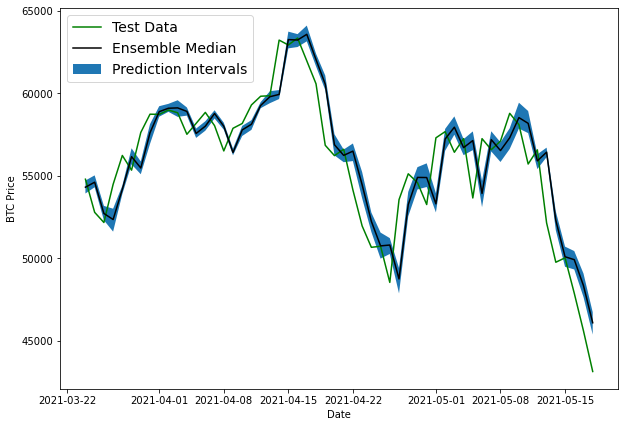

In [152]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

## Model 9: Train a model on the full historical data to make predictions into future



In [153]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [154]:
# Train model on entire data to make prediction for the next day 
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [155]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

And now let's create a model similar to `model_1` except with an extra layer, we'll also fit it to the entire dataset for 100 epochs (feel free to play around with the number of epochs or callbacks here, you've got the skills to now).

In [156]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) # don't print out anything, we've seen this all before

In [157]:
model_9.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_185 (Dense)           (None, 128)               1024      
                                                                 
 dense_186 (Dense)           (None, 128)               16512     
                                                                 
 dense_187 (Dense)           (None, 1)                 129       
                                                                 
Total params: 17,665
Trainable params: 17,665
Non-trainable params: 0
_________________________________________________________________


In [158]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days

In [159]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [160]:
# Make forecasts into future of the price of Bitcoin
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts 
# we're making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 217ms/step
Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55608.83203125

1/1 [==============================] - 0s 32ms/step
Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55608.83203125] -> Prediction: 51604.32421875

1/1 [==============================] - 0s 58ms/step
Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55608.83203125 51604.32421875] -> Prediction: 48771.9765625

1/1 [==============================] - 0s 21ms/step
Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55608.83203125 51604.32421875 48771.9765625 ] -> Prediction: 48968.40234375

1/1 [==============================] - 0s 22ms/step
Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55608.83203125
 51604.32421875 48771.9765625  48968.4

In [161]:
future_forecast[:10]

[55608.832,
 51604.324,
 48771.977,
 48968.402,
 47895.16,
 46694.938,
 48385.45,
 54374.14,
 50477.527,
 48264.277]

In [162]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

The start date of our forecasted dates will be the last date of our dataset. 

In [163]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [164]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

Look at that! We've now got a list of dates we can use to visualize our future Bitcoin predictions.

But to make sure the lines of the plot connect (try not running the cell below and then plotting the data to see what I mean), let's insert the last timestep and Bitcoin price of our training data to the `next_time_steps` and `future_forecast` arrays.

In [165]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55608.832, 51604.324, 48771.977, 48968.402, 47895.16 ,
        46694.938, 48385.45 , 54374.14 , 50477.527, 48264.277, 48913.473,
        48660.367, 48514.92 , 50631.812], dtype=float32))

Time to plot!

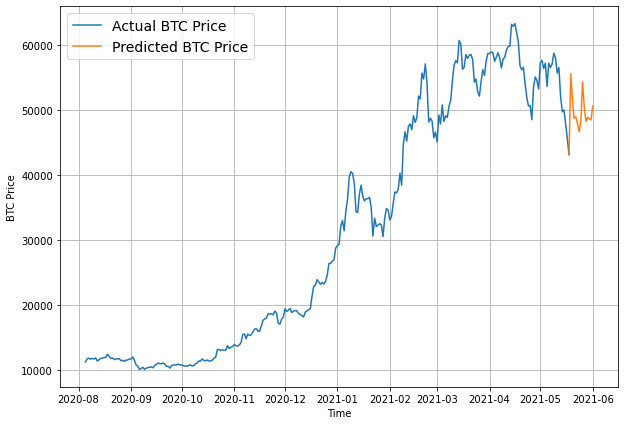

In [166]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

In [167]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                               }).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1147547.000,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,599.257996,1256225.625,1120.814697,2.713134,1.052730
model_2_dense_w30_h1,645.573364,1394154.000,1180.743042,3.011774,1.128469
model_3_dense_w30_h7,1285.247559,5613983.500,1477.187012,5.756607,2.287026
model_4_CONV1D,573.725525,1193796.875,1092.610107,2.568112,1.007877
model_5_LSTM,568.032776,1170161.875,1081.740234,2.541071,0.997876
model_6_multivariate,568.183228,1159775.750,1076.928833,2.529535,0.998141
model_8_NBEATs,572.326111,1131179.875,1063.569458,2.673580,1.005418
model_9_ensemble,564.431030,1138150.125,1066.841187,2.561604,0.991549


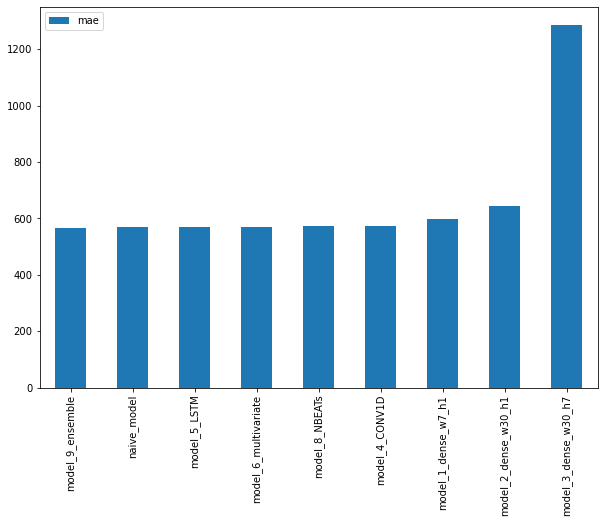

In [168]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");